In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


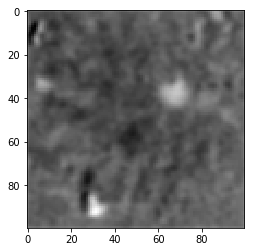

In [2]:
dataset = np.load('/home/kevinteng/Desktop//jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')
NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


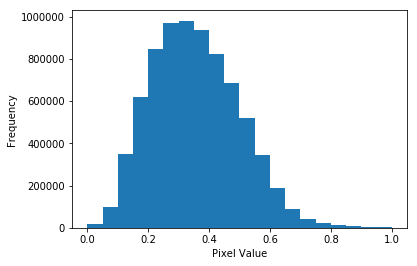

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Helper Function

In [5]:
def create_ran_numbers(img_size):
    '''
    Function to create random coordinates 
    
    @param img_size: Image size 
    
    return:
    random generated x,y coordinates 
    '''
    c1=np.random.randint(img_size, size=1)
    c2=np.random.randint(img_size, size=1)
    c1=tf.convert_to_tensor( c1,dtype=None,dtype_hint=None,name=None)
    c2=tf.convert_to_tensor( c2,dtype=None,dtype_hint=None,name=None)
    return c1,c2

@tf.function
def create_tf_tilecords(coord_list, img_size):
    o1,o2=coord_list
    multiply=tf.constant([img_size*img_size])
    y1=tf.reshape(tf.tile(o1,multiply),[img_size,img_size,1])
    y2=tf.reshape(tf.tile(o2,multiply),[img_size,img_size,1])

    y=tf.concat((y1,y2),axis=2)

    return tf.dtypes.cast(y, tf.float32),tf.dtypes.cast(coord_list, tf.float32)

@tf.function
def tf_create_onehotcords(dat):
    o1,o2=dat
    y1=tf.one_hot(o1,100)
    y2=tf.one_hot(o2,100)
    y2=tf.transpose(y2)
    y=tf.math.multiply(y1,y2)
    #y=tf.transpose(y)
    return y

def create_dat_samples(n):
    '''
    Function to create stacks of coordinates, tiled coordinates, one hot images
    @param n: number of neurons
    '''
    ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    tb = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    coords = tf.TensorArray(tf.float32, size=0, dynamic_size = True)
    for _ in tf.range(n):
        dat=create_ran_numbers(img_size=100)
        b1,b2=create_tf_tilecords(dat, 100)
        c1=tf_create_onehotcords(dat)
        c1=tf.expand_dims(c1, axis=2, name=None)
        
        #tile coordinates
        ta = ta.write(_, b1/99)  #(n, img_size, img_size, 1)
        #one hot images
        tb = tb.write(_, c1) #(n, img_size, img_size, 1)
        #coordinates
        coords = coords.write(_, dat) #(n, 2, 1)
    return coords.stack(), ta.stack(),tb.stack()

def neuron_like_image(n_neurons):
    '''
    Function to paint neuron-like images
     @param n_neurons: number of neurons
    '''
    _,_,one_hot_imgs = create_dat_samples(n_neurons)
    stack_imgs = tf.reduce_sum(one_hot_imgs, axis = 0)
    return tf.expand_dims(stack_imgs, axis = 0) #(1, img_size, img_size, 1)

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

---

# Validation

In [6]:
n_neurons = 120
img_size = 100
coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[120 1 1 2]


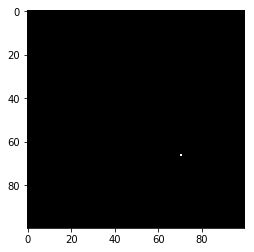

In [7]:
plt.imshow(tf.squeeze(ori_one_hot_imgs[0]), cmap = 'gray')

-----------------------------------

# Model

In [8]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers

def encoder(inps, img_size):
    #1st block
    coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 32, kernel_size = 3, padding='same')(inps)
    leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
    coord02 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky01)
    leaky02 = tf.keras.layers.LeakyReLU(0.5)(coord02)
    add01 = tf.keras.layers.Add()([leaky02, inps])
    
    #2nd block
    coord03 =  CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                      filters = 128, kernel_size = 3, padding='same')(add01)
    leaky03 = tf.keras.layers.LeakyReLU(0.5)(coord03)
    coord04 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky03)
    leaky04 = tf.keras.layers.LeakyReLU(0.5)(coord04)
    add02 = tf.keras.layers.Add()([leaky04, add01])
    
    #3rd block
    coord05 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 256, kernel_size = 3, padding='same')(add02)
    leaky05 = tf.keras.layers.LeakyReLU(0.5)(coord05)
    coord06 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky05)
    leaky06 = tf.keras.layers.LeakyReLU(0.5)(coord06)
    add03 = tf.keras.layers.Add()([leaky06, add02])

    #4th block
    coord07 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128, kernel_size = 3, padding='same')(add03)
    leaky07 = tf.keras.layers.LeakyReLU(0.5)(coord07)
    coord08 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky07)
    leaky08 = tf.keras.layers.LeakyReLU(0.5)(coord08)
    add04 =tf.keras.layers.Add()([leaky08, add03])
    
    #5th block
    coord09 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 64, kernel_size = 3, padding='same')(add04)
    leaky09 = tf.keras.layers.LeakyReLU(0.5)(coord09)
    coord10=CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky09)
    leaky10 = tf.keras.layers.LeakyReLU(0.5)(coord10)
    add05 = tf.keras.layers.Add()([leaky10, add04])
    
    #6th block
    coord11 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 32, kernel_size = 3, padding='same')(add05)
    leaky11 = tf.keras.layers.LeakyReLU(0.5)(coord11)
    coord12 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky11)
    leaky12 = tf.keras.layers.LeakyReLU(0.5)(coord12)
    add06 = tf.keras.layers.Add()([leaky12, coord11])
    output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', padding='same')(add06)
    
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
    squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y
    
def dataset_parse(dataset_path, NEW_SIZE):
    dataset = np.load(dataset_path)
    #re_list = dataset
    re_list = utils.resize(dataset, NEW_SIZE)
    #Dimension for network should include the color channel 
    re_list = np.expand_dims(re_list, axis = -1)
    #Cast data type to float32 for TensorFlow
    # re_list = re_list.astype('float32')
    re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
    
    return re_list

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

def similarity_multi(n_neurons, one_hot_imgs, similarity_score, img_size):
    '''
    @param n_neurons: number of neurons
    @param one_hot_imgs: one hot images generated by deconve model (100,100,1)
    @param similarity_scores: similarity scores after dot product
    @param img_size: image size 
    
    This function multiply the similarity scores with the one hot image generate by a particular
    coordinate 
    
    return:
    the sum of all the one hot image activations along the last channel
    '''
    stack_imgs = np.zeros((img_size,img_size))
    for idx in range(n_neurons):
        activations = similarity_score[idx]*np.squeeze(one_hot_imgs[idx])
        stack_imgs+= activations
        
    return stack_imgs #(batch_size, img_size, img_size)

In [9]:
# def encoder02(inps, img_size):
#     #1st block
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same')(inps)
#     leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')(leaky01 )
#     leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [10]:
#build encoder 
inps = Input(shape=(img_size, img_size, 1))
encoder_model = Model(inps, encoder(inps, img_size))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

In [11]:
# encoder_model.summary()

## Train Model

--------------------------------------

In [12]:
lr=0.001
opt = tf.keras.optimizers.Adam(lr)
loss_fn = tf.losses.MeanSquaredError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size):
    with tf.GradientTape() as tape:
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #output from encoder 
        encoder_output = encoder_model(inp_imgs)
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, coords, batch_size)#(batch_size, n_neurons, 3, 1)
        #reconstruction 
        reconstruction = decoder_model(latent)
        loss = loss_fn(inp_imgs, reconstruction)
        
    varis = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(loss, varis)
#     grad_coords = tape.gradient(loss, l_coords.trainable_variables)
    opt.apply_gradients(zip(grad_model, varis))
#     opt.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model 

In [13]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

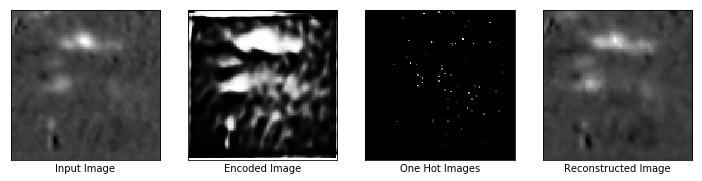

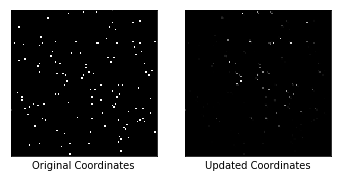

Epochs: 100, Loss: 0.0016274917870759964
Max Similarity scores: 0.999750554561615
Updated Coordinates: [[[0.7132816 0.6714515]]]
Gradient min:-0.0051043275743722916, max:0.0030459552071988583



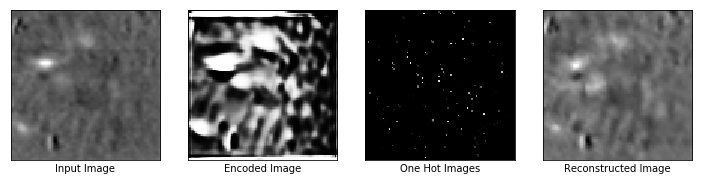

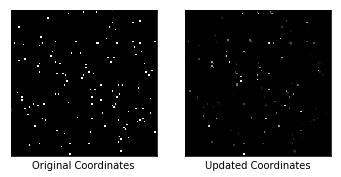

Epochs: 200, Loss: 0.0014151803916320205
Max Similarity scores: 0.9999899864196777
Updated Coordinates: [[[0.71677536 0.6756715 ]]]
Gradient min:-0.00016448840324301273, max:0.00011372434528311715



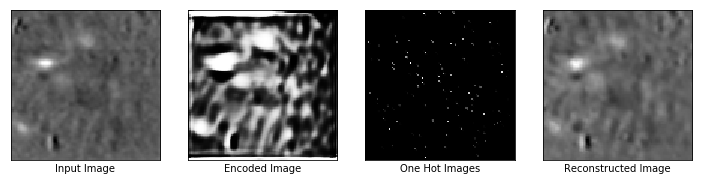

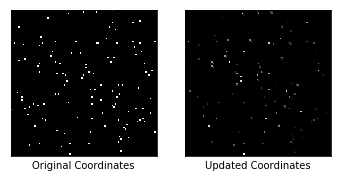

Epochs: 300, Loss: 0.0008280685287900269
Max Similarity scores: 0.99980628490448
Updated Coordinates: [[[0.7197231 0.6755016]]]
Gradient min:-1.916090513987001e-05, max:0.00010167162690777332



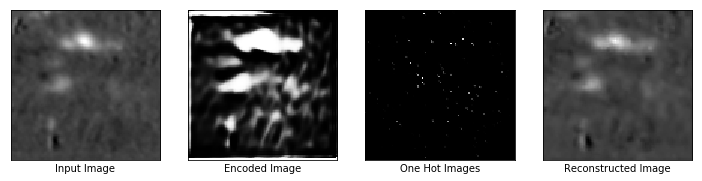

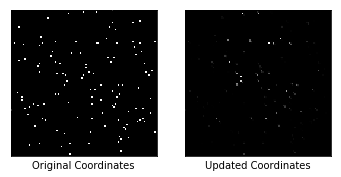

Epochs: 400, Loss: 0.0009831697680056095
Max Similarity scores: 0.9999754428863525
Updated Coordinates: [[[0.7209452 0.67794  ]]]
Gradient min:-0.001749374670907855, max:0.0003892788663506508



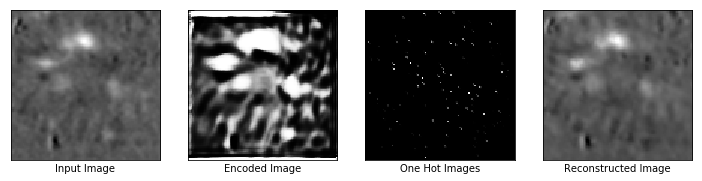

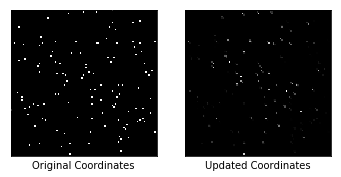

Epochs: 500, Loss: 0.002021726919338107
Max Similarity scores: 0.9999566674232483
Updated Coordinates: [[[0.72150207 0.67875856]]]
Gradient min:-0.0005718949832953513, max:0.00046300364192575216



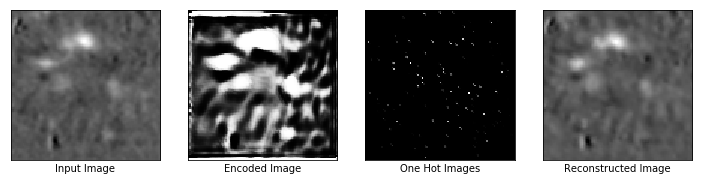

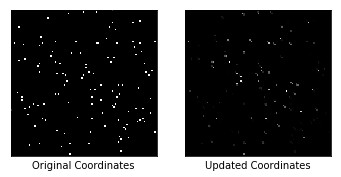

Epochs: 600, Loss: 0.0011385130928829312
Max Similarity scores: 0.9999987483024597
Updated Coordinates: [[[0.7217886 0.6789365]]]
Gradient min:-0.00017894018674269319, max:0.00026481860550120473



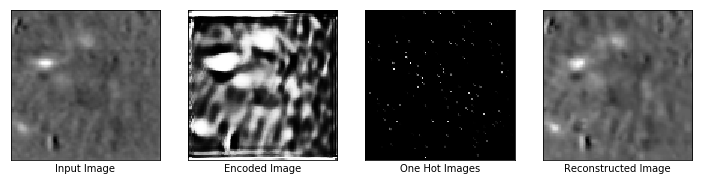

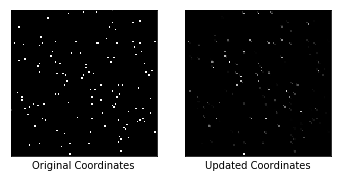

Epochs: 700, Loss: 0.0007002517231740057
Max Similarity scores: 0.9997624754905701
Updated Coordinates: [[[0.72145164 0.67914665]]]
Gradient min:-7.795900455676019e-05, max:5.146459079696797e-05



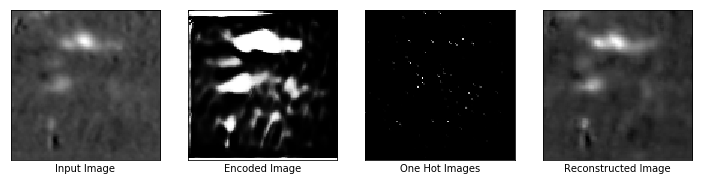

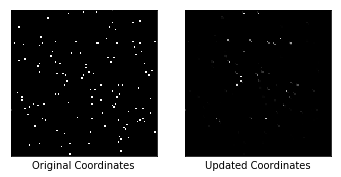

Epochs: 800, Loss: 0.002577659673988819
Max Similarity scores: 1.0000001192092896
Updated Coordinates: [[[0.7218735  0.67949563]]]
Gradient min:-0.006705280859023333, max:0.000914108008146286



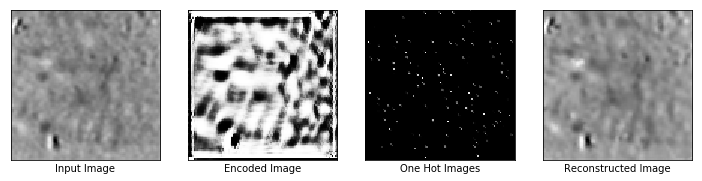

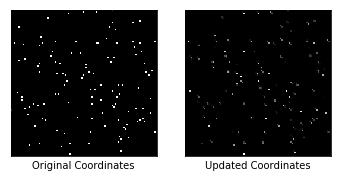

Epochs: 900, Loss: 0.0017224315088242292
Max Similarity scores: 0.9999470710754395
Updated Coordinates: [[[0.72197753 0.67895013]]]
Gradient min:-0.0007593607879243791, max:-0.0007593607879243791



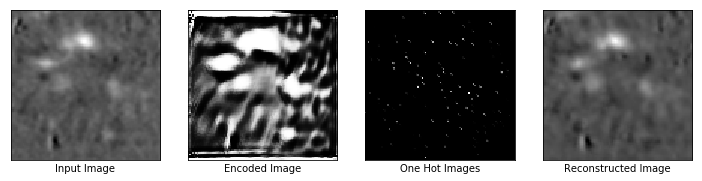

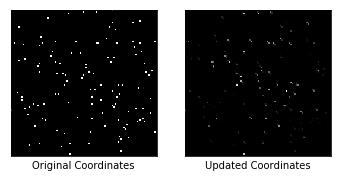

Epochs: 1000, Loss: 0.0007359707960858941
Max Similarity scores: 0.9999852776527405
Updated Coordinates: [[[0.7221349 0.6796141]]]
Gradient min:-0.00018360550166107714, max:0.0002790236030705273



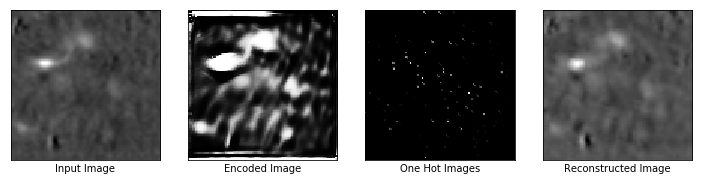

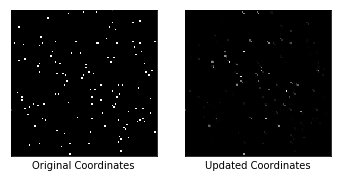

Epochs: 1100, Loss: 0.0008603667374700308
Max Similarity scores: 0.9998862743377686
Updated Coordinates: [[[0.72284245 0.6798075 ]]]
Gradient min:-0.0003730023745447397, max:-0.0003730023745447397



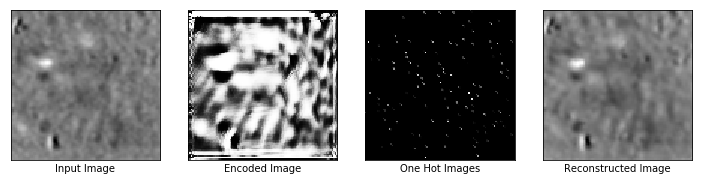

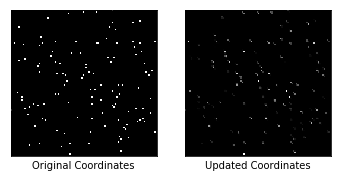

Epochs: 1200, Loss: 0.0006736723589710891
Max Similarity scores: 0.999988853931427
Updated Coordinates: [[[0.72344244 0.6787567 ]]]
Gradient min:-0.00011498846288304776, max:3.411237048567273e-05



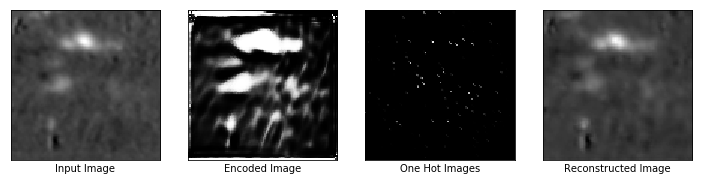

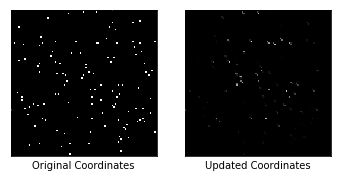

Epochs: 1300, Loss: 0.0008380598155781627
Max Similarity scores: 0.9999943375587463
Updated Coordinates: [[[0.722611   0.67866087]]]
Gradient min:-0.00171956536360085, max:0.00022208195878192782



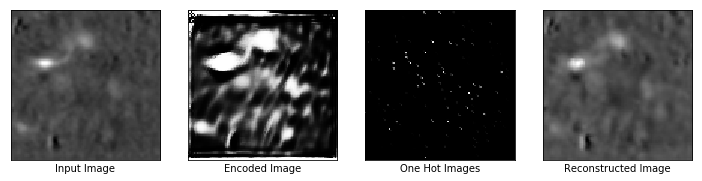

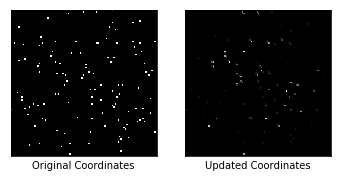

Epochs: 1400, Loss: 0.0008017089567147195
Max Similarity scores: 0.9998490810394287
Updated Coordinates: [[[0.72324747 0.6802052 ]]]
Gradient min:0.0004959049401804805, max:0.0004959049401804805



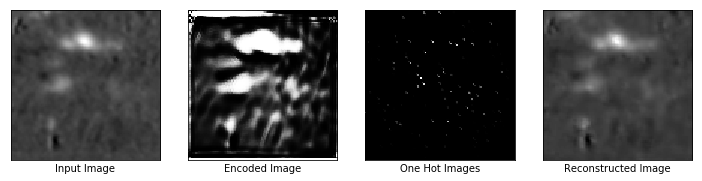

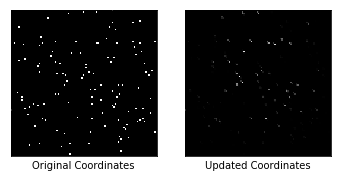

Epochs: 1500, Loss: 0.0008250545361079276
Max Similarity scores: 0.9999567866325378
Updated Coordinates: [[[0.72387266 0.6790721 ]]]
Gradient min:-0.00022769905626773834, max:0.001568507170304656



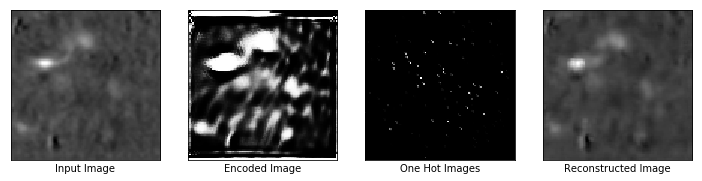

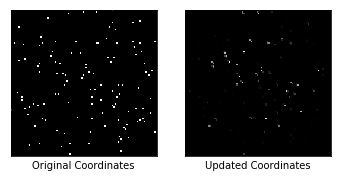

Epochs: 1600, Loss: 0.0007456510793417692
Max Similarity scores: 0.9999905228614807
Updated Coordinates: [[[0.72426397 0.679561  ]]]
Gradient min:-0.0006521522882394493, max:-0.0006521522882394493



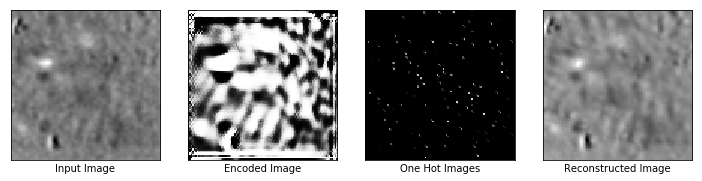

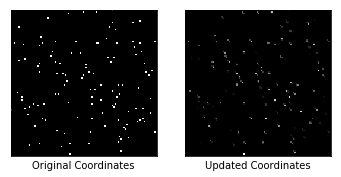

Epochs: 1700, Loss: 0.0010880957124754786
Max Similarity scores: 0.9999775290489197
Updated Coordinates: [[[0.7228282 0.6799375]]]
Gradient min:-0.0002255349390907213, max:0.00016292714281007648



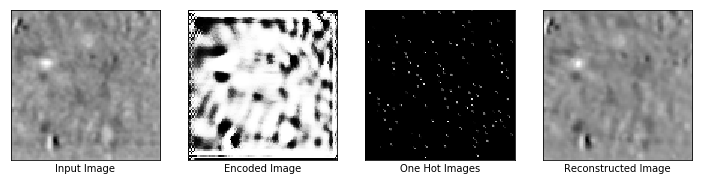

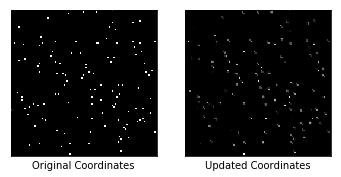

Epochs: 1800, Loss: 0.0008016055217012763
Max Similarity scores: 0.9999985098838806
Updated Coordinates: [[[0.7234023 0.6795323]]]
Gradient min:-0.00029435413307510316, max:0.00023799804330337793



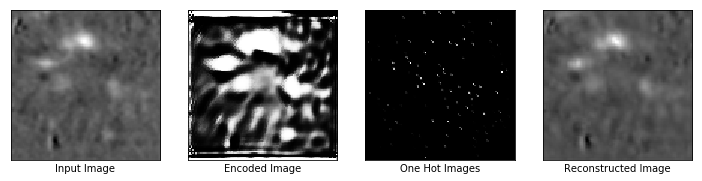

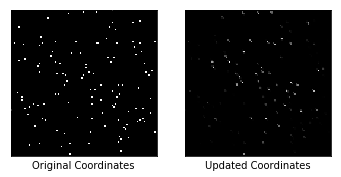

Epochs: 1900, Loss: 0.001011467189528048
Max Similarity scores: 0.9999925494194031
Updated Coordinates: [[[0.7240989 0.6804465]]]
Gradient min:-0.0006681648083031178, max:0.0008084652945399284



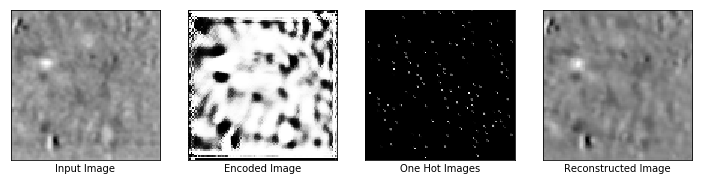

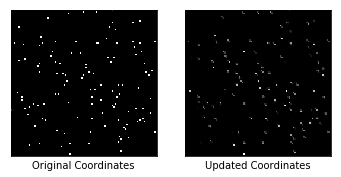

Epochs: 2000, Loss: 0.0008001484093256295
Max Similarity scores: 0.9999660849571228
Updated Coordinates: [[[0.72371197 0.68045336]]]
Gradient min:-0.00021645780361723155, max:0.00026834194432012737


In [14]:
from random import randint, seed

BATCH_SIZE = 8
MAX_EPOCHS = 2000
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model  = train_fn(batched_imgs, coords, IMG_SIZE, BATCH_SIZE)
    #loss is append for each epochs
    loss_list.append(loss)
    
    rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
    if epochs%100==0:
        img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE), reconstruction[rand]]
        img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Loss: {}".format(epochs, loss.numpy()))
        print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient min:{}, max:{}".format(np.min(grad_model[rand]), np.max(grad_model[rand])))
    #append list for every 100 epochs 
#     if epochs%100==0:
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1

----

# Save Output Data

In [31]:
save_list = [loss_list, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save('npy/{}_full05.npy'.format(names), np.array(tensor))
    

In [32]:
#save coords amd one hot images()
np.save('npy/{}_full05.npy'.format('ori_coords'), np.array(coords))
np.save('npy/{}_full05.npy'.format('ori_one_hot_imgs'), np.array(ori_one_hot_imgs))

---

# Visualization

In [33]:
coords_list_npy = np.load('npy/{}_full05.npy'.format('coords_list')) 
encoded_imgs_npy = np.load('npy/{}_full05.npy'.format('encoded_imgs'))
input_imgs_npy = np.load('npy/{}_full05.npy'.format('input_imgs'))
loss_list_npy = np.load('npy/{}_full05.npy'.format('loss_list'))
one_hot_imgs_list_npy = np.load('npy/{}_full05.npy'.format('one_hot_imgs_list'))
reconstructed_imgs_npy = np.load('npy/{}_full05.npy'.format('reconstructed_imgs'))
similarity_list_npy = np.load('npy/{}_full05.npy'.format('similarity_list'))
ori_coords_npy = np.load('npy/{}_full05.npy'.format('ori_coords'))
ori_one_hot_imgs_npy = np.load('npy/{}_full05.npy'.format('ori_one_hot_imgs'))

In [34]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

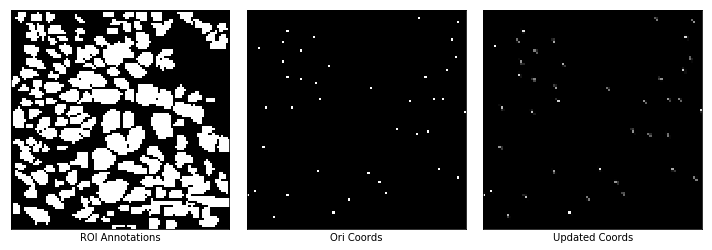

In [7]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

In [8]:
print(similarity_list_npy.shape)
print(one_hot_imgs_list_npy.shape)

(20, 8, 40)
(20, 40, 100, 100, 1)


In [24]:
def similarity_multiplication(n_neurons, epoch_pos, img_size):
    stack_batch_imgs = []
    for batch_similarity in similarity_list_npy[epoch_pos]:
        stack_imgs = np.zeros((img_size,img_size))
        for idx in range(n_neurons):
            test = batch_similarity[idx]*np.squeeze(one_hot_imgs_list_npy[epoch_pos, idx])
            stack_imgs+=test
        stack_batch_imgs.append(stack_imgs)
    return np.array(stack_batch_imgs) #(batch_size, img_size, img_size)

In [25]:
neuron_activations = similarity_multiplication(n_neurons, epoch_pos=-1)

In [21]:
reconstructed_imgs_npy.shape

(20, 8, 100, 100, 1)

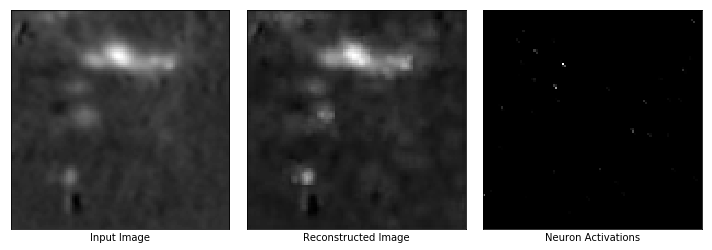

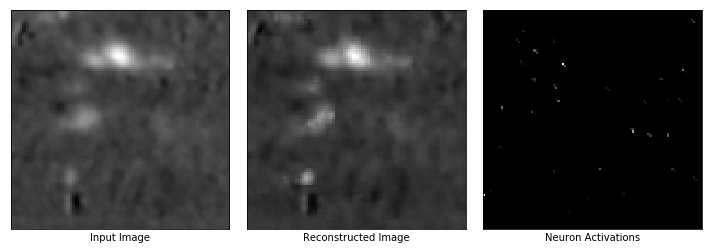

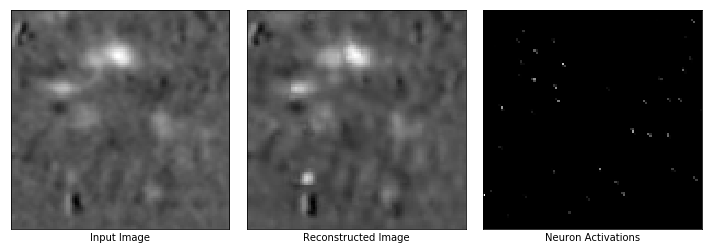

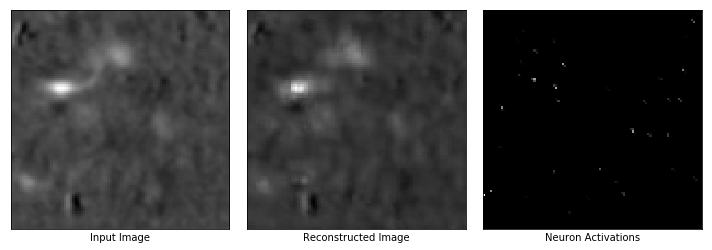

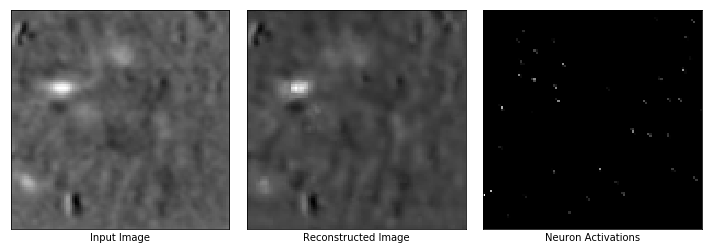

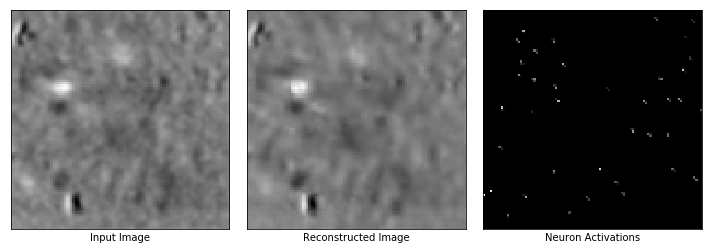

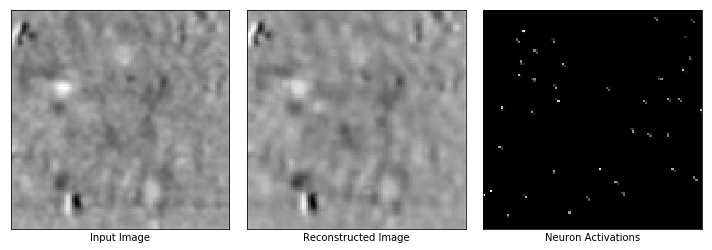

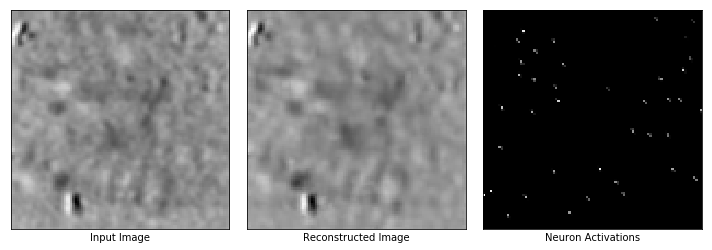

In [23]:
batch_size = 8
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

In [ ]:
#checking coords of highest and lowest similarity score

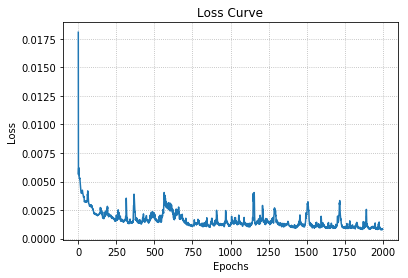

In [5]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_npy, xlabel, ylabel, title)